## Coding Exercise #0805

In [1]:
#To enable CPU execution only
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# Available backend options are: "jax", "tensorflow", "torch".
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

### 1. Time series and prediction:

In [3]:
import time
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data and explore:

In [4]:
!wget --no-clobber https://raw.githubusercontent.com/tn-220/SIC-Machine-Learning/main/SIC_ML_Coding_Exercises/SIC_ML_Chapter_09_Coding_Exercises/data_time_series.csv

File ‘data_time_series.csv’ already there; not retrieving.



In [5]:
df = pd.read_csv('data_time_series.csv', header='infer',encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

(41, 1)


In [6]:
# Display the data frame.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


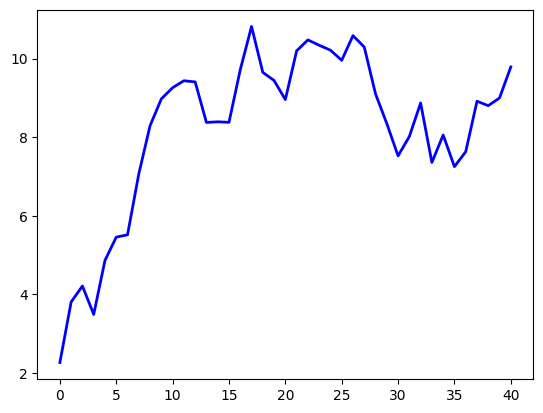

In [7]:
# Visualize the time series.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. Apply the exponential smoothing method and predict:

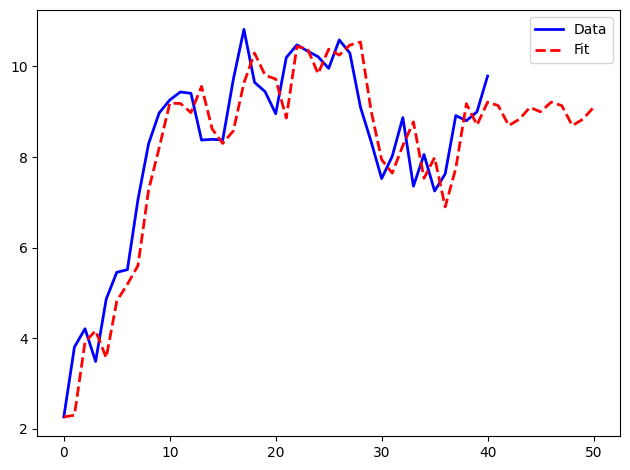

In [8]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start= 0, end=50)
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Recurrent neural network (RNN):

#### 2.1. Pre-processing:

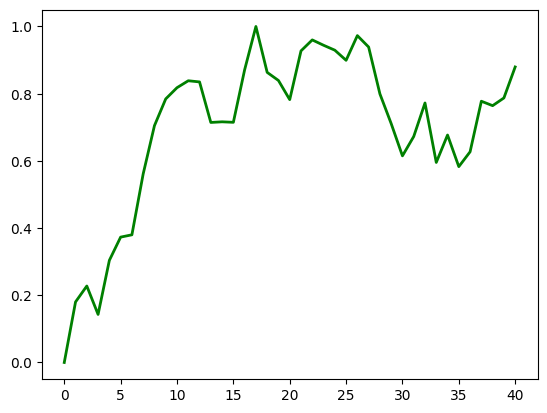

In [9]:
# Scaling.
# Please, pay attention to the vertical scale of the plot.
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [10]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

#### 2.2. Do the necessary definitions:

Hyperparameters.

In [11]:
n_epochs = 1001
batch_size = 1                    # There is only 1 time series data. No other choice but 1.
learn_rate = 0.0002

In [12]:
n_input = 1                       # Scalar input.
n_neurons = 100                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

Model.

In [13]:
# RNN or LSTM network.
# return_sequnces = True: means "Sequence to Sequence".
# input_shape = (None, n_inputs) : variable length of the time series.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))     # RNN.
#my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [14]:
# View the summary.
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 100)      │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define the optimizer and compile.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [16]:
import time

#### 2.3. Train the model:

In [17]:
# No validation.
# CAUTION: y is X shifted by +1.
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

21.638815879821777


In [15]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

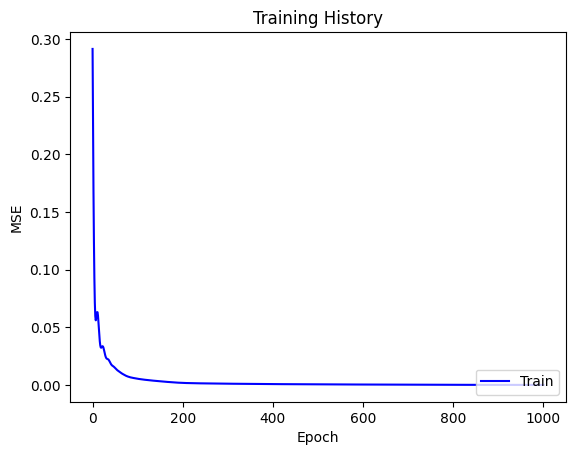

In [18]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

#### 2.4. Predict the future:

In [19]:
n_ts_seed = 5                                 # Seed length.
n_predict_time_steps = 55                     # Prediction length.

In [20]:
# Prediction loop.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.
    y_pred = my_model(X, training=False)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

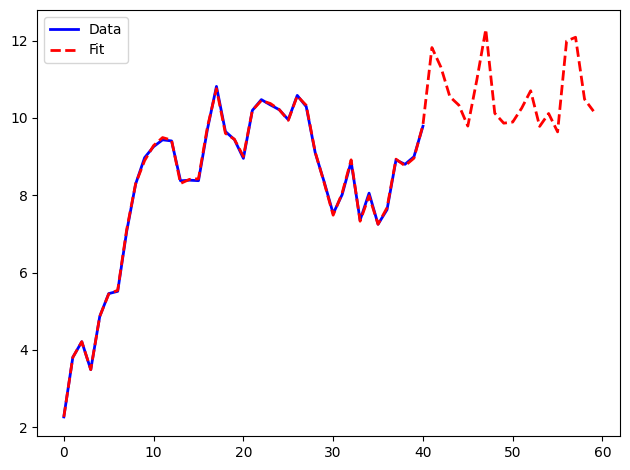

In [21]:
# Do the inverse transform and show the times series.
ts = scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.tight_layout()
plt.savefig("out.png")
plt.show()